## statsitical anslysis of source estimates

In [ ]:
# permutation t-test on source data with spatio-temporal clustering

In [1]:
import numpy as np
from numpy.random import randn
from scipy import stats as stats

import mne
from mne.epochs import equalize_epoch_counts
from mne.stats import (spatio_temporal_cluster_1samp_test,
                       summarize_clusters_stc)
from mne.minimum_norm import apply_inverse, read_inverse_operator
from mne.datasets import sample

In [2]:
data_path = sample.data_path()
meg_path = data_path / 'MEG' / 'sample'
raw_fname = meg_path / 'sample_audvis_filt-0-40_raw.fif'
event_fname = meg_path / 'sample_audvis_filt-0-40_raw-eve.fif'
subjects_dir = data_path / 'subjects'
src_fname = subjects_dir / 'fsaverage' / 'bem' / 'fsaverage-ico-5-src.fif'

tmin = -0.2
tmax = 0.3  # Use a lower tmax to reduce multiple comparisons

# Setup for reading the raw data
raw = mne.io.read_raw_fif(raw_fname)
events = mne.read_events(event_fname)

Opening raw data file /Users/DanDan/mne_data/MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.


In [3]:
raw.info['bads'] += ['MEG 2443']
picks = mne.pick_types(raw.info, meg=True, eog=True, exclude='bads')
event_id = 1  # L auditory
reject = dict(grad=1000e-13, mag=4000e-15, eog=150e-6)
epochs1 = mne.Epochs(raw, events, event_id, tmin, tmax, picks=picks,
                     baseline=(None, 0), reject=reject, preload=True)

event_id = 3  # L visual
epochs2 = mne.Epochs(raw, events, event_id, tmin, tmax, picks=picks,
                     baseline=(None, 0), reject=reject, preload=True)

# Equalize trial counts to eliminate bias (which would otherwise be
# introduced by the abs() performed below)
equalize_epoch_counts([epochs1, epochs2])

Not setting metadata
72 matching events found
Setting baseline interval to [-0.19979521315838786, 0.0] sec
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 3)
4 projection items activated
Loading data for 72 events and 76 original time points ...
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on MAG : ['MEG 1711']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
9 bad epochs dropped
Not setting metadata
73 matching events found
Setting baseline interval to [-0.19979521315838786, 0.0] sec
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 3)
4 projection items activated
Loading data for 73 events and 76

In [4]:
fname_inv = meg_path / 'sample_audvis-meg-oct-6-meg-inv.fif'
snr = 3.0
lambda2 = 1.0 / snr ** 2
method = "dSPM"  # use dSPM method (could also be MNE, sLORETA, or eLORETA)
inverse_operator = read_inverse_operator(fname_inv)
sample_vertices = [s['vertno'] for s in inverse_operator['src']]

# Let's average and compute inverse, resampling to speed things up
evoked1 = epochs1.average()
evoked1.resample(50, npad='auto')
condition1 = apply_inverse(evoked1, inverse_operator, lambda2, method)
evoked2 = epochs2.average()
evoked2.resample(50, npad='auto')
condition2 = apply_inverse(evoked2, inverse_operator, lambda2, method)

# Let's only deal with t > 0, cropping to reduce multiple comparisons
condition1.crop(0, None)
condition2.crop(0, None)
tmin = condition1.tmin
tstep = condition1.tstep * 1000  # convert to milliseconds

Reading inverse operator decomposition from /Users/DanDan/mne_data/MNE-sample-data/MEG/sample/sample_audvis-meg-oct-6-meg-inv.fif...
    Reading inverse operator info...
    [done]
    Reading inverse operator decomposition...
    [done]
    305 x 305 full covariance (kind = 1) found.
    Read a total of 4 projection items:
        PCA-v1 (1 x 102) active
        PCA-v2 (1 x 102) active
        PCA-v3 (1 x 102) active
        Average EEG reference (1 x 60) active
    Noise covariance matrix read.
    22494 x 22494 diagonal covariance (kind = 2) found.
    Source covariance matrix read.
    22494 x 22494 diagonal covariance (kind = 6) found.
    Orientation priors read.
    22494 x 22494 diagonal covariance (kind = 5) found.
    Depth priors read.
    Did not find the desired covariance matrix (kind = 3)
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
    Computing p

In [5]:
## transform to common cortical space
n_vertices_sample, n_times = condition1.data.shape
n_subjects = 6
print(f'Simulating data for {n_subjects} subjects.')

# Let's make sure our results replicate, so set the seed.
np.random.seed(0)
X = randn(n_vertices_sample, n_times, n_subjects, 2) * 10
X[:, :, :, 0] += condition1.data[:, :, np.newaxis]
X[:, :, :, 1] += condition2.data[:, :, np.newaxis]


Simulating data for 6 subjects.


In [6]:
# Read the source space we are morphing to
src = mne.read_source_spaces(src_fname)
fsave_vertices = [s['vertno'] for s in src]
morph_mat = mne.compute_source_morph(
    src=inverse_operator['src'], subject_to='fsaverage',
    spacing=fsave_vertices, subjects_dir=subjects_dir).morph_mat

n_vertices_fsave = morph_mat.shape[0]

# We have to change the shape for the dot() to work properly
X = X.reshape(n_vertices_sample, n_times * n_subjects * 2)
print('Morphing data.')
X = morph_mat.dot(X)  # morph_mat is a sparse matrix
X = X.reshape(n_vertices_fsave, n_times, n_subjects, 2)

    Reading a source space...
    [done]
    Reading a source space...
    [done]
    2 source spaces read
surface source space present ...
Computing morph matrix...
    Left-hemisphere map read.
    Right-hemisphere map read.
    17 smooth iterations done.
    14 smooth iterations done.
[done]
[done]
Morphing data.


In [7]:
X = np.abs(X)  # only magnitude
X = X[:, :, :, 0] - X[:, :, :, 1]  # make paired contrast

In [8]:
print('Computing adjacency.')
adjacency = mne.spatial_src_adjacency(src)

Computing adjacency.
-- number of adjacent vertices : 20484


In [9]:
# Note that X needs to be a multi-dimensional array of shape
# observations (subjects) × time × space, so we permute dimensions
X = np.transpose(X, [2, 1, 0])

# Here we set a cluster forming threshold based on a p-value for
# the cluster based permutation test.
# We use a two-tailed threshold, the "1 - p_threshold" is needed
# because for two-tailed tests we must specify a positive threshold.
p_threshold = 0.001
df = n_subjects - 1  # degrees of freedom for the test
t_threshold = stats.distributions.t.ppf(1 - p_threshold / 2, df=df)

# Now let's actually do the clustering. This can take a long time...
print('Clustering.')
T_obs, clusters, cluster_p_values, H0 = clu = \
    spatio_temporal_cluster_1samp_test(X, adjacency=adjacency, n_jobs=None,
                                       threshold=t_threshold, buffer_size=None,
                                       verbose=True)

Clustering.
stat_fun(H1): min=-31.563537 max=62.791547
Running initial clustering …
Found 368 clusters


  0%|          | Permuting (exact test) : 0/31 [00:00<?,       ?it/s]

In [10]:
# Select the clusters that are statistically significant at p < 0.05
good_clusters_idx = np.where(cluster_p_values < 0.05)[0]
good_clusters = [clusters[idx] for idx in good_clusters_idx]

Visualizing clusters.
Using notebook 3d backend.



<IPython.core.display.Javascript object>


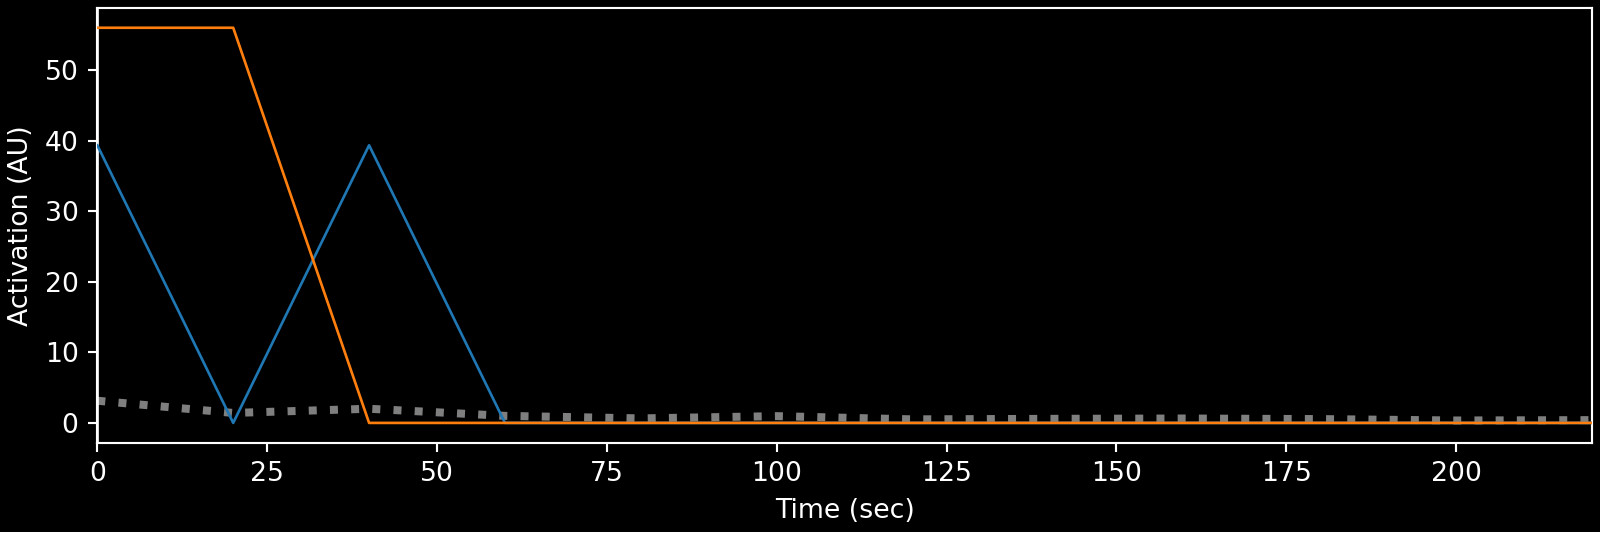

In [12]:
print('Visualizing clusters.')

# Now let's build a convenient representation of our results, where consecutive
# cluster spatial maps are stacked in the time dimension of a SourceEstimate
# object. This way by moving through the time dimension we will be able to see
# subsequent cluster maps.
stc_all_cluster_vis = summarize_clusters_stc(clu, tstep=tstep,
                                             vertices=fsave_vertices,
                                             subject='fsaverage')

# Let's actually plot the first "time point" in the SourceEstimate, which
# shows all the clusters, weighted by duration.

# blue blobs are for condition A < condition B, red for A > B
brain = stc_all_cluster_vis.plot(
    hemi='both', views='lateral', subjects_dir=subjects_dir,
    time_label='temporal extent (ms)', size=(800, 800),
    smoothing_steps=5, clim=dict(kind='value', pos_lims=[0, 1, 40]))

# We could save this via the following:
# brain.save_image('clusters.png')

## 2 samples permutation test

In [13]:
import numpy as np
from scipy import stats as stats

import mne
from mne import spatial_src_adjacency
from mne.stats import spatio_temporal_cluster_test, summarize_clusters_stc
from mne.datasets import sample

print(__doc__)

Automatically created module for IPython interactive environment


In [14]:
data_path = sample.data_path()
meg_path = data_path / 'MEG' / 'sample'
stc_fname = meg_path / 'sample_audvis-meg-lh.stc'
subjects_dir = data_path / 'subjects'
src_fname = subjects_dir / 'fsaverage' / 'bem' / 'fsaverage-ico-5-src.fif'

# Load stc to in common cortical space (fsaverage)
stc = mne.read_source_estimate(stc_fname)
stc.resample(50, npad='auto')

# Read the source space we are morphing to
src = mne.read_source_spaces(src_fname)
fsave_vertices = [s['vertno'] for s in src]
morph = mne.compute_source_morph(stc, 'sample', 'fsaverage',
                                 spacing=fsave_vertices, smooth=20,
                                 subjects_dir=subjects_dir)
stc = morph.apply(stc)
n_vertices_fsave, n_times = stc.data.shape
tstep = stc.tstep * 1000  # convert to milliseconds

n_subjects1, n_subjects2 = 6, 7
print('Simulating data for %d and %d subjects.' % (n_subjects1, n_subjects2))

#    Let's make sure our results replicate, so set the seed.
np.random.seed(0)
X1 = np.random.randn(n_vertices_fsave, n_times, n_subjects1) * 10
X2 = np.random.randn(n_vertices_fsave, n_times, n_subjects2) * 10
X1[:, :, :] += stc.data[:, :, np.newaxis]
# make the activity bigger for the second set of subjects
X2[:, :, :] += 3 * stc.data[:, :, np.newaxis]

#    We want to compare the overall activity levels for each subject
X1 = np.abs(X1)  # only magnitude
X2 = np.abs(X2)  # only magnitude

    Reading a source space...
    [done]
    Reading a source space...
    [done]
    2 source spaces read
surface source space present ...
Computing morph matrix...
    Left-hemisphere map read.
    Right-hemisphere map read.
    20 smooth iterations done.
    20 smooth iterations done.
[done]
[done]
Simulating data for 6 and 7 subjects.


In [15]:
print('Computing adjacency.')
adjacency = spatial_src_adjacency(src)

#    Note that X needs to be a list of multi-dimensional array of shape
#    samples (subjects_k) × time × space, so we permute dimensions
X1 = np.transpose(X1, [2, 1, 0])
X2 = np.transpose(X2, [2, 1, 0])
X = [X1, X2]

# Now let's actually do the clustering. This can take a long time...
# Here we set the threshold quite high to reduce computation,
# and use a very low number of permutations for the same reason.
n_permutations = 50
p_threshold = 0.001
f_threshold = stats.distributions.f.ppf(1. - p_threshold / 2.,
                                        n_subjects1 - 1, n_subjects2 - 1)
print('Clustering.')
F_obs, clusters, cluster_p_values, H0 = clu =\
    spatio_temporal_cluster_test(
        X, adjacency=adjacency, n_jobs=None, n_permutations=n_permutations,
        threshold=f_threshold, buffer_size=None)
#    Now select the clusters that are sig. at p < 0.05 (note that this value
#    is multiple-comparisons corrected).
good_cluster_inds = np.where(cluster_p_values < 0.05)[0]

Computing adjacency.
-- number of adjacent vertices : 20484
Clustering.
stat_fun(H1): min=0.000000 max=303.632172
Running initial clustering …
Found 361 clusters


  0%|          | Permuting : 0/49 [00:00<?,       ?it/s]

Visualizing clusters.


<IPython.core.display.Javascript object>


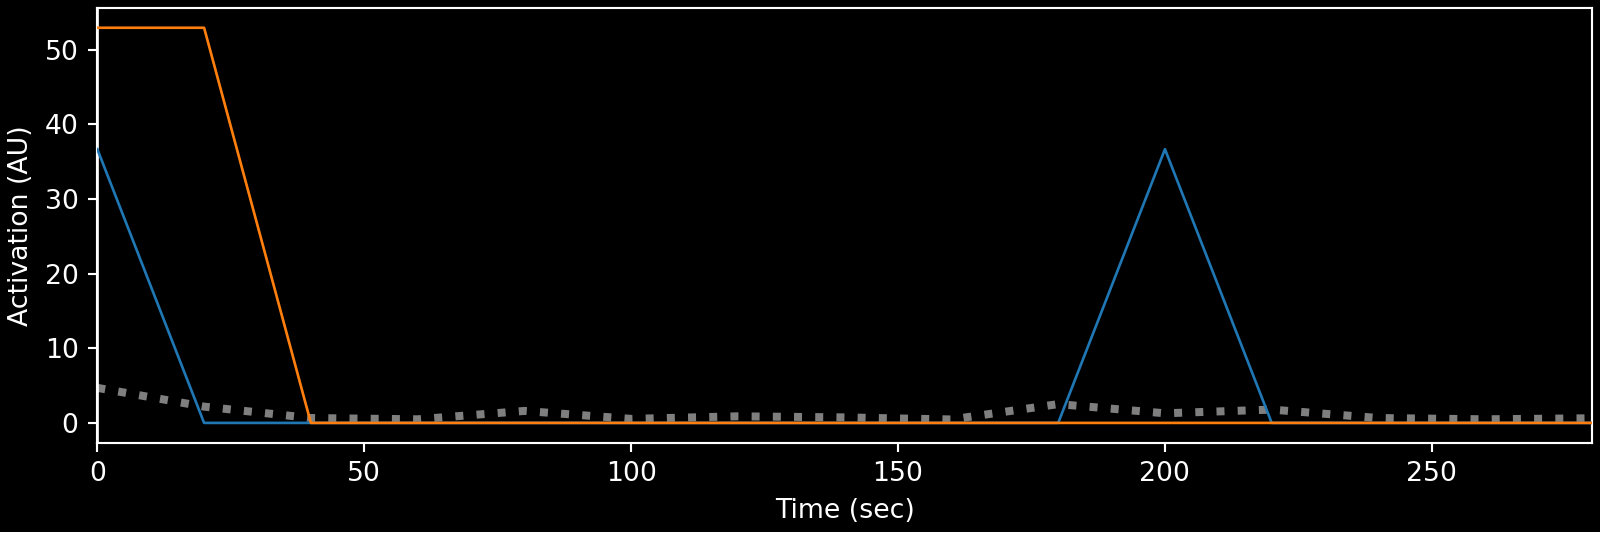

In [16]:
print('Visualizing clusters.')

#    Now let's build a convenient representation of each cluster, where each
#    cluster becomes a "time point" in the SourceEstimate
fsave_vertices = [np.arange(10242), np.arange(10242)]
stc_all_cluster_vis = summarize_clusters_stc(clu, tstep=tstep,
                                             vertices=fsave_vertices,
                                             subject='fsaverage')

#    Let's actually plot the first "time point" in the SourceEstimate, which
#    shows all the clusters, weighted by duration

# blue blobs are for condition A != condition B
brain = stc_all_cluster_vis.plot('fsaverage', hemi='both',
                                 views='lateral', subjects_dir=subjects_dir,
                                 time_label='temporal extent (ms)',
                                 clim=dict(kind='value', lims=[0, 1, 40]))

## repeated measures ANOVA on source data with spatio-temporal clustering

In [17]:
import os.path as op
import numpy as np
from numpy.random import randn
import matplotlib.pyplot as plt

import mne
from mne.stats import (spatio_temporal_cluster_test, f_threshold_mway_rm,
                       f_mway_rm, summarize_clusters_stc)

from mne.minimum_norm import apply_inverse, read_inverse_operator
from mne.datasets import sample

print(__doc__)

Automatically created module for IPython interactive environment


In [18]:
data_path = sample.data_path()
meg_path = data_path / 'MEG' / 'sample'
raw_fname = meg_path / 'sample_audvis_filt-0-40_raw.fif'
event_fname = meg_path / 'sample_audvis_filt-0-40_raw-eve.fif'
subjects_dir = data_path / 'subjects'
src_fname = subjects_dir / 'fsaverage' / 'bem' / 'fsaverage-ico-5-src.fif'

tmin = -0.2
tmax = 0.3  # Use a lower tmax to reduce multiple comparisons

#   Setup for reading the raw data
raw = mne.io.read_raw_fif(raw_fname)
events = mne.read_events(event_fname)

Opening raw data file /Users/DanDan/mne_data/MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.


In [19]:
raw.info['bads'] += ['MEG 2443']
picks = mne.pick_types(raw.info, meg=True, eog=True, exclude='bads')
# we'll load all four conditions that make up the 'two ways' of our ANOVA

event_id = dict(l_aud=1, r_aud=2, l_vis=3, r_vis=4)
reject = dict(grad=1000e-13, mag=4000e-15, eog=150e-6)
epochs = mne.Epochs(raw, events, event_id, tmin, tmax, picks=picks,
                    baseline=(None, 0), reject=reject, preload=True)

#    Equalize trial counts to eliminate bias (which would otherwise be
#    introduced by the abs() performed below)
epochs.equalize_event_counts(event_id)

Not setting metadata
288 matching events found
Setting baseline interval to [-0.19979521315838786, 0.0] sec
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 3)
4 projection items activated
Loading data for 288 events and 76 original time points ...
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on MAG : ['MEG 1711']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['E

(<Epochs |  240 events (all good), -0.199795 - 0.299693 sec, baseline -0.199795 – 0 sec, ~45.8 MB, data loaded,
  'l_aud': 60
  'r_aud': 60
  'l_vis': 60
  'r_vis': 60>,
 array([ 13, 198, 201,  32,  35,  52, 199, 222,   0,  14,  33, 151, 166,
        168, 200]))

In [ ]:
# transform to source space

In [20]:
fname_inv = meg_path / 'sample_audvis-meg-oct-6-meg-inv.fif'
snr = 3.0
lambda2 = 1.0 / snr ** 2
method = "dSPM"  # use dSPM method (could also be MNE, sLORETA, or eLORETA)
inverse_operator = read_inverse_operator(fname_inv)

# we'll only use one hemisphere to speed up this example
# instead of a second vertex array we'll pass an empty array
sample_vertices = [inverse_operator['src'][0]['vertno'], np.array([], int)]

#    Let's average and compute inverse, then resample to speed things up
conditions = []
for cond in ['l_aud', 'r_aud', 'l_vis', 'r_vis']:  # order is important
    evoked = epochs[cond].average()
    evoked.resample(30).crop(0., None)
    condition = apply_inverse(evoked, inverse_operator, lambda2, method)
    #    Let's only deal with t > 0, cropping to reduce multiple comparisons
    condition.crop(0, None)
    conditions.append(condition)

tmin = conditions[0].tmin
tstep = conditions[0].tstep * 1000  # convert to milliseconds

Reading inverse operator decomposition from /Users/DanDan/mne_data/MNE-sample-data/MEG/sample/sample_audvis-meg-oct-6-meg-inv.fif...
    Reading inverse operator info...
    [done]
    Reading inverse operator decomposition...
    [done]
    305 x 305 full covariance (kind = 1) found.
    Read a total of 4 projection items:
        PCA-v1 (1 x 102) active
        PCA-v2 (1 x 102) active
        PCA-v3 (1 x 102) active
        Average EEG reference (1 x 60) active
    Noise covariance matrix read.
    22494 x 22494 diagonal covariance (kind = 2) found.
    Source covariance matrix read.
    22494 x 22494 diagonal covariance (kind = 6) found.
    Orientation priors read.
    22494 x 22494 diagonal covariance (kind = 5) found.
    Depth priors read.
    Did not find the desired covariance matrix (kind = 3)
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
    Computing p

In [21]:
# transform to common cortical space
n_vertices_sample, n_times = conditions[0].lh_data.shape
n_subjects = 6
print('Simulating data for %d subjects.' % n_subjects)

#    Let's make sure our results replicate, so set the seed.
np.random.seed(0)
X = randn(n_vertices_sample, n_times, n_subjects, 4) * 10
for ii, condition in enumerate(conditions):
    X[:, :, :, ii] += condition.lh_data[:, :, np.newaxis]


Simulating data for 6 subjects.


In [22]:
# Read the source space we are morphing to (just left hemisphere)
src = mne.read_source_spaces(src_fname)
fsave_vertices = [src[0]['vertno'], []]
morph_mat = mne.compute_source_morph(
    src=inverse_operator['src'], subject_to='fsaverage',
    spacing=fsave_vertices, subjects_dir=subjects_dir, smooth=20).morph_mat
morph_mat = morph_mat[:, :n_vertices_sample]  # just left hemi from src
n_vertices_fsave = morph_mat.shape[0]

#    We have to change the shape for the dot() to work properly
X = X.reshape(n_vertices_sample, n_times * n_subjects * 4)
print('Morphing data.')
X = morph_mat.dot(X)  # morph_mat is a sparse matrix
X = X.reshape(n_vertices_fsave, n_times, n_subjects, 4)

    Reading a source space...
    [done]
    Reading a source space...
    [done]
    2 source spaces read
surface source space present ...
Computing morph matrix...
    Left-hemisphere map read.
    Right-hemisphere map read.
    20 smooth iterations done.
    20 smooth iterations done.
[done]
[done]
Morphing data.


In [23]:
X = np.transpose(X, [2, 1, 0, 3])  #
X = [np.squeeze(x) for x in np.split(X, 4, axis=-1)]

In [24]:
factor_levels = [2, 2]

effects = 'A:B'
# Tell the ANOVA not to compute p-values which we don't need for clustering
return_pvals = False

# a few more convenient bindings
n_times = X[0].shape[1]
n_conditions = 4


def stat_fun(*args):
    # get f-values only.
    return f_mway_rm(np.swapaxes(args, 1, 0), factor_levels=factor_levels,
                     effects=effects, return_pvals=return_pvals)[0]

In [25]:
# compute clustering statistic

# as we only have one hemisphere we need only need half the adjacency
print('Computing adjacency.')
adjacency = mne.spatial_src_adjacency(src[:1])

# Now let's actually do the clustering. Please relax, on a small
# notebook and one single thread only this will take a couple of minutes ...
pthresh = 0.005
f_thresh = f_threshold_mway_rm(n_subjects, factor_levels, effects, pthresh)

# To speed things up a bit we will ...
n_permutations = 50  # ... run way fewer permutations (reduces sensitivity)

print('Clustering.')
F_obs, clusters, cluster_p_values, H0 = clu = \
    spatio_temporal_cluster_test(X, adjacency=adjacency, n_jobs=None,
                                 threshold=f_thresh, stat_fun=stat_fun,
                                 n_permutations=n_permutations,
                                 buffer_size=None)
# Now select the clusters that are sig. at p < 0.05 (note that this value
# is multiple-comparisons corrected).
good_cluster_inds = np.where(cluster_p_values < 0.05)[0]

Computing adjacency.
-- number of adjacent vertices : 10242
Clustering.
stat_fun(H1): min=0.000000 max=1782.851281
Running initial clustering …
Found 444 clusters


  0%|          | Permuting : 0/49 [00:00<?,       ?it/s]

Visualizing clusters.


<IPython.core.display.Javascript object>


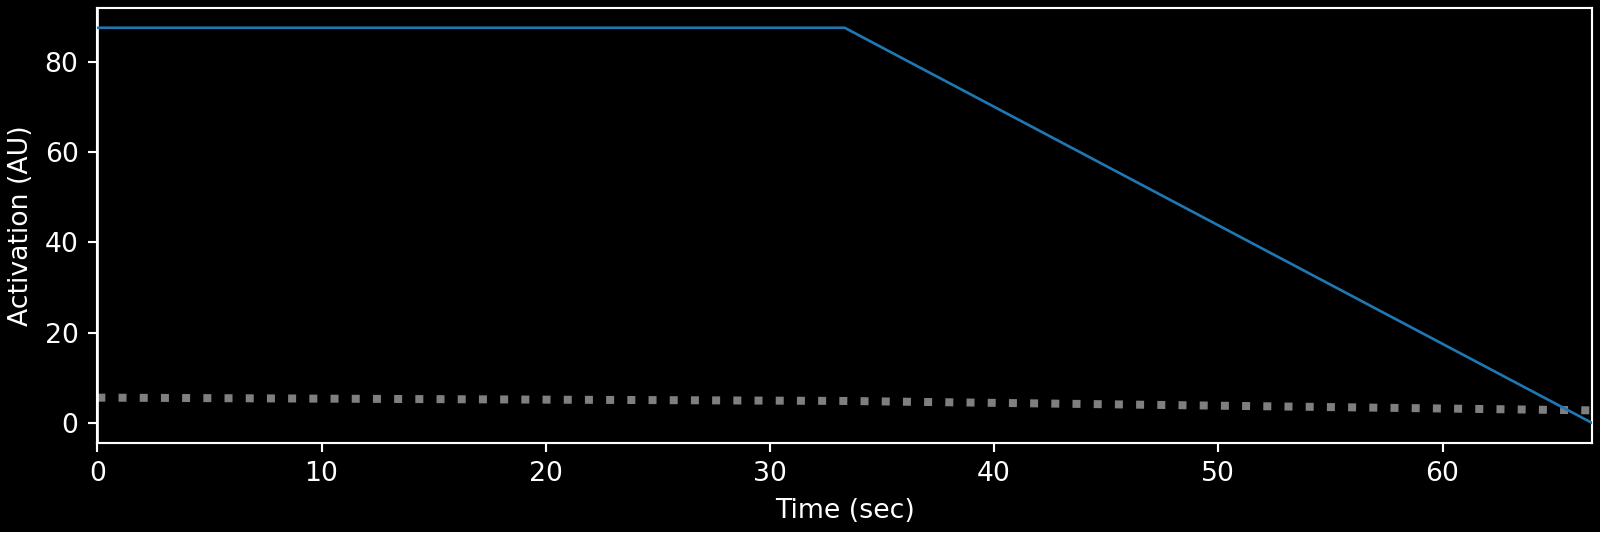

In [26]:
print('Visualizing clusters.')

#    Now let's build a convenient representation of each cluster, where each
#    cluster becomes a "time point" in the SourceEstimate
stc_all_cluster_vis = summarize_clusters_stc(clu, tstep=tstep,
                                             vertices=fsave_vertices,
                                             subject='fsaverage')

#    Let's actually plot the first "time point" in the SourceEstimate, which
#    shows all the clusters, weighted by duration

subjects_dir = op.join(data_path, 'subjects')
# The brighter the color, the stronger the interaction between
# stimulus modality and stimulus location

brain = stc_all_cluster_vis.plot(subjects_dir=subjects_dir, views='lat',
                                 time_label='temporal extent (ms)',
                                 clim=dict(kind='value', lims=[0, 1, 40]))
brain.save_image('cluster-lh.png')
brain.show_view('medial')

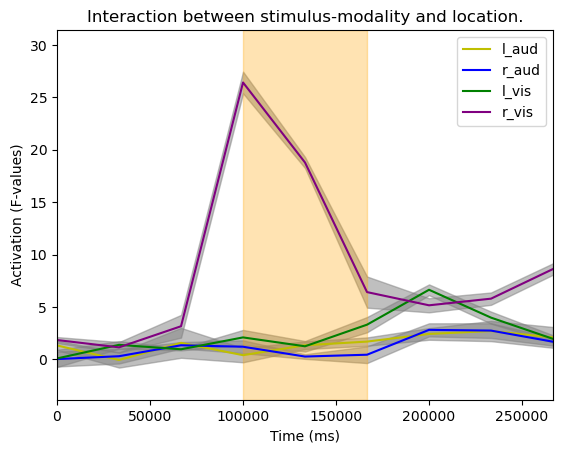

In [27]:
inds_t, inds_v = [(clusters[cluster_ind]) for ii, cluster_ind in
                  enumerate(good_cluster_inds)][0]  # first cluster

times = np.arange(X[0].shape[1]) * tstep * 1e3

plt.figure()
colors = ['y', 'b', 'g', 'purple']
event_ids = ['l_aud', 'r_aud', 'l_vis', 'r_vis']

for ii, (condition, color, eve_id) in enumerate(zip(X, colors, event_ids)):
    # extract time course at cluster vertices
    condition = condition[:, :, inds_v]
    # normally we would normalize values across subjects but
    # here we use data from the same subject so we're good to just
    # create average time series across subjects and vertices.
    mean_tc = condition.mean(axis=2).mean(axis=0)
    std_tc = condition.std(axis=2).std(axis=0)
    plt.plot(times, mean_tc.T, color=color, label=eve_id)
    plt.fill_between(times, mean_tc + std_tc, mean_tc - std_tc, color='gray',
                     alpha=0.5, label='')

ymin, ymax = mean_tc.min() - 5, mean_tc.max() + 5
plt.xlabel('Time (ms)')
plt.ylabel('Activation (F-values)')
plt.xlim(times[[0, -1]])
plt.ylim(ymin, ymax)
plt.fill_betweenx((ymin, ymax), times[inds_t[0]],
                  times[inds_t[-1]], color='orange', alpha=0.3)
plt.legend()
plt.title('Interaction between stimulus-modality and location.')
plt.show()